# 最大公共子结构
rdkit中提供了在多个分子间查找最大公共子结构（Maximum Common Substructure, MCS）的功能。该功能可以应用在相同骨架搜索、分子库分析、寻找药效团等场景中。
## 1.搜索方法
* FindMCS(mols)
mols：待搜索的分子集
在多个结构中寻找最大公共子结构。该函数返回一个MCSResult实例，实例含有以下属性：
 - 搜索到结构的mol对象：MCSResult.queryMol
 - 搜索到结构的原子数：MCSResult.numAtoms
 - 搜索到结构的键数量：MCSResult.numBonds
 - 搜索到结构的smarts：MCSResult.smartsString
 - 搜索是否超时：MCSResult.canceled

如果没有找到MCS，原子和键会记录为0，SMARTS为空。

10
10
False
[#6]1(-[#6]):[#6]:[#6](-[#8]-[#6]):[#6](:[#6]:[#6]:1)-[#8]


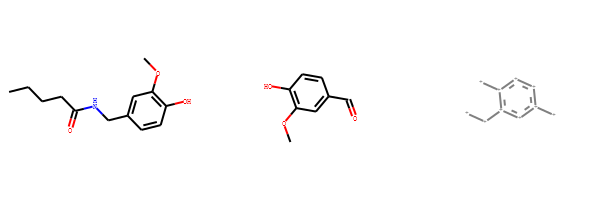

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
mol1 = Chem.MolFromSmiles("CCCCC(=O)NCC1=CC(=C(C=C1)O)OC")
mol2 = Chem.MolFromSmiles("c1(C=O)cc(OC)c(O)cc1")
mols = [mol1, mol2]

res = rdFMCS.FindMCS(mols)
print(res.numAtoms)
print(res.numBonds)
print(res.canceled)
print(res.smartsString)
mols.append(res.queryMol)
img = Draw.MolsToGridImage(mols)
img

## 2.bondCompare参数
默认情况下，当两个分子中对应的原子和键完全一样时，才认为它们是一致的。可以通过修改atomCompare和bondCompare参数，来进行模糊匹配。以模糊匹配键为例。
* 初始化两个分子

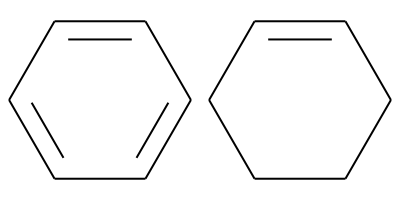

In [2]:
mols = [Chem.MolFromSmiles('c1ccccc1'), Chem.MolFromSmiles('C1CCCC=C1')]
img = Draw.MolsToGridImage(mols, molsPerRow=2)
img

In [3]:
img.save('data/mcs2.png')

* CompareOrderExact：默认值为该方法。当且仅当键的类型完全一致才相等（芳香键和双键是不相等的）。

In [4]:
res = rdFMCS.FindMCS(mols, bondCompare=rdFMCS.BondCompare.CompareOrderExact).smartsString
print(res) # 结果为空

* CompareAny：任意键之间都可以匹配

[#6]1:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,=[#6]:,-1


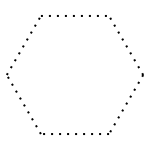

In [5]:
res = rdFMCS.FindMCS(mols, bondCompare=rdFMCS.BondCompare.CompareAny).smartsString
print(res)
m = Chem.MolFromSmarts(res)
img = Draw.MolToImage(m, size=(150,150))
img

In [6]:
img.save('data/mcs3.png')

* CompareOrder：允许单键和芳香键相互匹配。

[#6](:,-[#6]:,-[#6]:,-[#6]):,-[#6]:,-[#6]


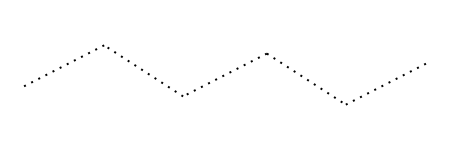

In [7]:
res = rdFMCS.FindMCS(mols, bondCompare=rdFMCS.BondCompare.CompareOrder).smartsString
print(res)
m = Chem.MolFromSmarts(res)
m

## 3.atomCompare参数
与bondCompare参数类似，可用设置如下：
* CompareElements：默认值，原子类型一样才算匹配。
* CompareIsotopes：同位素一样才算匹配（根据同位素标签的值。这个值可以由用户自己定义）。
* CompareAny：表示任意原子之间都能匹配（找公共骨架）。

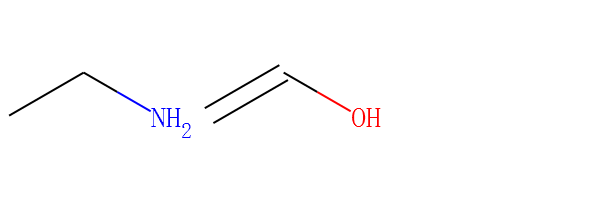

In [8]:
mols = (Chem.MolFromSmiles('NCC'), Chem.MolFromSmiles('OC=C'))
Draw.MolsToGridImage(mols)

[#7,#8]-[#6]-,=[#6]


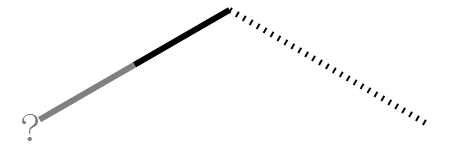

In [9]:
res = rdFMCS.FindMCS(mols, atomCompare=rdFMCS.AtomCompare.CompareAny, bondCompare=rdFMCS.BondCompare.CompareAny).smartsString
m = Chem.MolFromSmarts(res)
print(res)
m

## 4.maximizeBonds参数
一个结构由原子和键组成。默认情况下，MCS查找的目标是让键的数量最大化，相当于让环的数量最大化。最大化键的数量时，会使环的数量最大化，但也可能出现两个小环键的数量不如一个大环多的情况。可以通过将maximizeBonds参数设为False来取消设置。（暂时还不知道怎么使用）

## 5.matchValences参数
默认False，即忽略化合价信息。假设要考虑化合价信息，例如不想让一个3价氮与一个5价氮匹配上，那就可以将该参数改为True

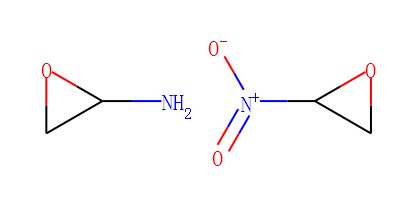

In [10]:
mols = (Chem.MolFromSmiles('NC1OC1'), Chem.MolFromSmiles('C1OC1[N+](=O)[O-]'))
img = Draw.MolsToGridImage(mols, molsPerRow=2)
img

In [11]:
img.save('data/mcs4.png')

In [12]:
print(rdFMCS.FindMCS(mols).numAtoms)
print(rdFMCS.FindMCS(mols, matchValences=True).numBonds)

4
3


## 6.ringMatchesRingOnly参数
不做设置时，默认为False，这种情况下，线性的碳链可能会匹配上一个环。如果只想让环相互匹配，可以将该参数设置为True。

In [13]:
mols = [Chem.MolFromSmiles("C1CCC1CCC"), Chem.MolFromSmiles("C1CCCCCC1")]
res1 = rdFMCS.FindMCS(mols)
print(res1.numAtoms)
res2 = rdFMCS.FindMCS(mols, ringMatchesRingOnly=True)
print(res2.numAtoms)
mols += [res1.queryMol, res2.queryMol]

7
4


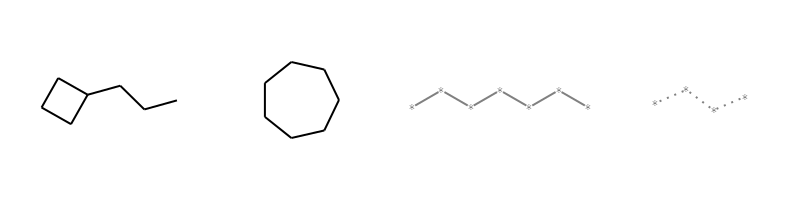

In [14]:
img = Draw.MolsToGridImage(mols, molsPerRow=4)
img

In [15]:
img.save('data/mcs5.png')

## 7.completeRingsOnly参数
默认为False。如果只想要能够完整匹配上的环，而不想要匹配一半的环，可以将该参数设置为True。

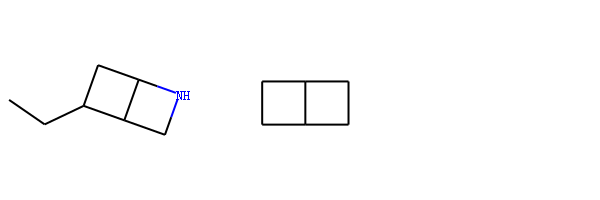

In [16]:
mols = [Chem.MolFromSmiles("CCC1CC2C1CN2"), Chem.MolFromSmiles("C1CC2C1CC2")]
Draw.MolsToGridImage(mols)

[#6]1-[#6]-[#6](-[#6]-1-[#6])-[#6]


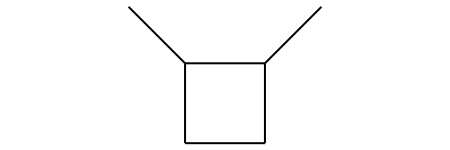

In [17]:
res = rdFMCS.FindMCS(mols).smartsString
print(res)
m = Chem.MolFromSmarts(res)
m

[#6]1-&@[#6]-&@[#6]-&@[#6]-&@1


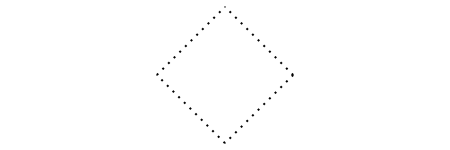

In [18]:
res = rdFMCS.FindMCS(mols, completeRingsOnly=True).smartsString
print(res)
m = Chem.MolFromSmarts(res)
m

* 环的设置可以叠加使用

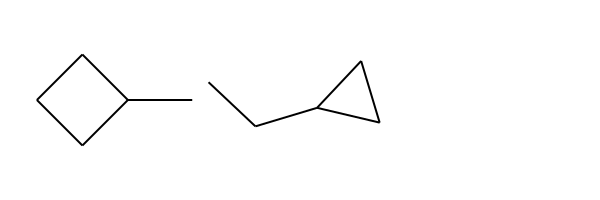

In [19]:
ms = [Chem.MolFromSmiles(x) for x in ('CC1CCC1', 'CCC1CC1')]
Draw.MolsToGridImage(ms)

[#6]-[#6](-[#6]-[#6])-[#6]


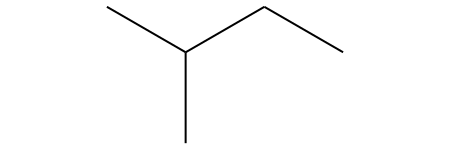

In [20]:
res = rdFMCS.FindMCS(ms).smartsString
print(res)
m = Chem.MolFromSmarts(res)
m

[#6&!R]-&!@[#6&R](-&@[#6&R])-&@[#6&R]


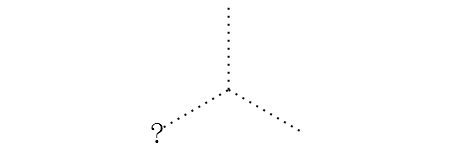

In [21]:
res = rdFMCS.FindMCS(ms, ringMatchesRingOnly=True).smartsString
print(res)
m = Chem.MolFromSmarts(res)
m

[#6]-&!@[#6]


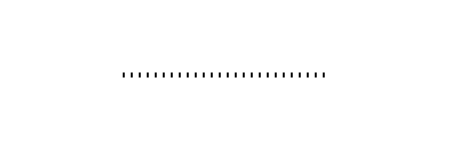

In [22]:
res = rdFMCS.FindMCS(ms, completeRingsOnly=True).smartsString
print(res)
m = Chem.MolFromSmarts(res)
m

[#6&!R]-&!@[#6&R]


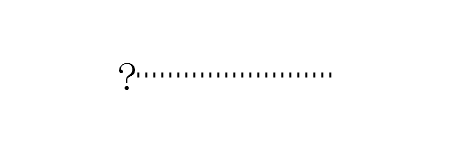

In [23]:
res = rdFMCS.FindMCS(ms, ringMatchesRingOnly=True, completeRingsOnly=True).smartsString
print(res)
m = Chem.MolFromSmarts(res)
m

## 8.timeout参数
MCS算法会穷尽每一种可能，寻找到一个最大的公共子结构。一般情况下说，该算法几秒内就能完成，但是有时也会花很长时间甚至花几分钟。这时，可以使用timeout参数来规定最大搜索时长，到达指定时长仍没有搜索完时，会返回现有的最优结果，并将canceled属性设置为True。该参数单位为秒。

In [24]:
mols = [Chem.MolFromSmiles("Nc1ccccc1"*10), Chem.MolFromSmiles("Nc1ccccccccc1"*10)]
rdFMCS.FindMCS(mols, timeout=1).canceled

True